In [32]:
def genome_pos(x):
    _chr, e_start, e_end, gene_id = x.split('-')
    e_start, e_end = int(e_start), int(e_end)
    distance = abs(e_start - gene_start)
    return distance

In [1]:
import os
import re
import glob
import pysam
import networkx as nx
import pandas as pd
import numpy as np
from itertools import combinations
from subprocess import check_output
import xarray as xr
from pybedtools import BedTool
from collections import defaultdict, Counter
import dask
from ALLCools.plot import *
from ALLCools.mcds import MCDS, RegionDS
from ALLCools.dmr import call_dms, call_dmr
import pathlib
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
from ALLCools.mcds.correlation import region_correlation, get_corr_table
from ALLCools.dmr.parse_methylpy import methylpy_to_region_ds
import seaborn as sns
from multiprocessing import Pool, Manager, Process
from functools import partial
import argparse
from pingouin import partial_corr
from ALLCools.mcds import MCDS
import cooler

In [2]:
ct = 'Oligo_NN'

In [3]:
chrom_size_path = '/ref/m3C/mm10.main.nochrM.nochrY.chrom.sizes'
gene_meta_path = '/data/metadata/gencode.vM22.basic.annotation.gene.flat.tsv.gz'
dmr_zarr_path = f"{ct}.AllDMR.mcds"
cool_path = '/data/female-amb/AMB.CoolFiles/CellType.Age.Raw.5kb.mcool'
leg = [f"{ct}.{age}" for age in ['8wk','9mo','18mo']]

In [4]:
mouse_chrs = ['chr' + str(x) for x in range(1,20)] + ['chrX']
mouse_size = pd.read_csv(chrom_size_path, sep="\t", index_col=0, names=['length']).loc[mouse_chrs]

In [5]:
mouse_genes = pd.read_csv(gene_meta_path,sep="\t")[['chrom', 'start', 'end', 'gene_id','gene_name']]
mouse_genes.columns = ['chrom', 'start', 'end', 'geneID','gene_name']
mouse_genes['geneID'] = [re.sub("\.[0-9]+$", "", x) for x in mouse_genes['geneID']]
mouse_genes.index = mouse_genes['geneID']
mouse_genes = mouse_genes[~mouse_genes['chrom'].isin(['chrY', 'chrM'])]

In [6]:
var_dim = 'AllDMR'
dmr_RDS = MCDS.open(dmr_zarr_path, obs_dim='sample', var_dim=var_dim )
dmr_RDS.add_mc_frac(var_dim=var_dim,  normalize_per_cell=False)

In [7]:
dmrbed = pd.DataFrame(
            [dmr_RDS.coords[f"{var_dim}_chrom"].to_pandas(),
             dmr_RDS.coords[f"{var_dim}_start"].to_pandas(),
             dmr_RDS.coords[f"{var_dim}_end"].to_pandas(),],index=["chrom", "start", "end"],).T
dmrbed.head()

,chrom,start,end
AllDMR,,,
chr1-3003639-3003639,chr1,3003639,3003641
chr1-3027143-3027143,chr1,3027143,3027145
chr1-3032861-3032861,chr1,3032861,3032863
chr1-3040554-3040554,chr1,3040554,3040632
chr1-3041273-3041273,chr1,3041273,3041275


In [8]:
group = leg[0]
gene_id = 'ENSMUSG00000024810'

In [9]:
def get_gene_abc_score(group, gene_id):
    ct_age_cool = cooler.Cooler(f'{cool_path}/{group}.raw.mcool::resolutions/10000')

    max_distance = 5000000
    ABC_score = defaultdict(dict)
    total_ABC = dict()
    
    gene_coords = mouse_genes.loc[gene_id].to_dict()
    chrom = gene_coords['chrom']
    gene_start = int(gene_coords['start']) - 2000
    gene_end = int(gene_coords['end']) + 2000
    
    start = int(gene_coords['start']) - max_distance
    end = int(gene_coords['start']) + max_distance
    start = 1 if start < 0 else start
    end = mouse_size.loc[chrom, 'length'] if end > mouse_size.loc[chrom, 'length'] else end

    ct_age_dmr = dmrbed
    gene_dmr = ct_age_dmr[(ct_age_dmr['chrom'] == gene_coords['chrom']) & (ct_age_dmr['start'] > start)
                                       & (ct_age_dmr['end'] < end)]
    gene_dmr = gene_dmr[gene_dmr['end'] - gene_dmr['start']>=10]

    dmr_mCG = dmr_RDS.sel({var_dim: gene_dmr.index, 'mc_type':'CGN'})[f'{var_dim}_da_frac'].to_pandas()
    dmr_mCG = dmr_mCG.loc[leg]
    dmr_activity = 1 - dmr_mCG
    dmr_activity_dict = dmr_activity.to_dict()

    # calculate interactions of each DMR to target gene
    dmr_contacts = defaultdict(dict)
    contacts = ct_age_cool.matrix(balance=False, as_pixels=True, join=True).fetch(f'{chrom}:{start}-{end}')

    gene_contacts_upper = contacts[(contacts['start1'] >= gene_start) & (contacts['start1'] <= gene_end)]
    gene_contacts_down = contacts[(contacts['start2'] >= gene_start) & (contacts['start2'] <= gene_end)]
    gene_contacts_upper = gene_contacts_upper[(gene_contacts_upper['start2'] >= gene_start) & (gene_contacts_upper['start2'] <= end)]
    gene_contacts_down = gene_contacts_down[(gene_contacts_down['start1'] >= start) & (gene_contacts_down['start1'] <= gene_start)]

    for z, row in gene_contacts_upper.iterrows():
        z_bin_dmrs = gene_dmr[(gene_dmr['start'] >= row.start2) & (gene_dmr['end'] <= row.end2)]         
        for dmr in z_bin_dmrs.index:
            dmr_contacts[dmr] = row['count']
    
    for y, row in gene_contacts_down.iterrows():
        y_bin_dmrs = gene_dmr[(gene_dmr['start'] >= row.start1) & (gene_dmr['end'] <= row.end1)]         
        for dmr in y_bin_dmrs.index:
            dmr_contacts[dmr] = row['count']
    
    for dmr in dmr_contacts:
        total_ABC = dmr_activity_dict[dmr][group] * dmr_contacts[dmr]
    
    gene_dmr['new_index'] = gene_dmr['chrom'] + '-' + gene_dmr['start'].astype(str) + '-' + gene_dmr['end'].astype(str) 
    old_to_new_dict = gene_dmr['new_index'].to_dict()

    for dmr in dmr_contacts:
        new_dmr = old_to_new_dict[dmr]
        EG = f'{new_dmr}-{gene_id}'
        try:
            activity = dmr_activity_dict[dmr][group]
            contact = dmr_contacts[dmr]
            ABC_score[EG] = activity, contact, (activity *  contact/ total_ABC)
        except:
            ABC_score[EG][celltype] = np.nan
    ABC_score_df = pd.DataFrame.from_dict(ABC_score, orient='index')
    #ABC_score_df.columns = [group]
    return ABC_score_df

In [10]:
young_abc_df= get_gene_abc_score(group= leg[0], gene_id = gene_id)
old_abc_df= get_gene_abc_score(group= leg[2], gene_id = gene_id)

In [16]:
young_abc_df = young_abc_df[young_abc_df[1] >= 5]
old_abc_df = old_abc_df[old_abc_df[1] >= 5]

In [34]:
young_abc_df['eg_dist'] = young_abc_df.index.map(lambda x: genome_pos(x))
old_abc_df['eg_dist'] = old_abc_df.index.map(lambda x: genome_pos(x))

In [35]:
shared_e_g_pairs = list(set(young_abc_df.index) & set(old_abc_df.index))
shared_e_g_pairs_num = len(shared_e_g_pairs)
shared_e_g_pairs_num

47

In [36]:
young_num = young_abc_df.shape[0]
old_num = old_abc_df.shape[0]

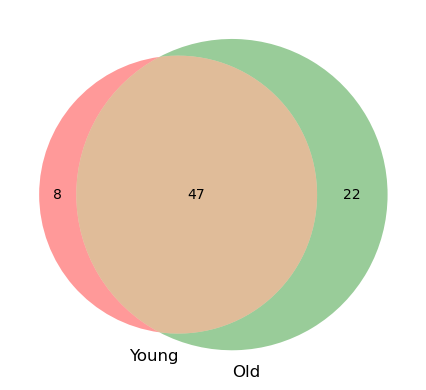

In [37]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

venn2(subsets = (young_num-shared_e_g_pairs_num, old_num-shared_e_g_pairs_num, shared_e_g_pairs_num), set_labels = ('Young', 'Old'))
plt.show()

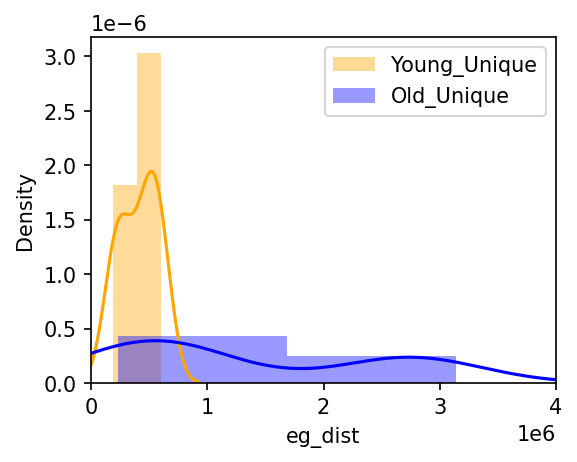

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(4, 3), dpi=150)

sns.distplot(young_abc_df.loc[~young_abc_df.index.isin(shared_e_g_pairs)]['eg_dist'],
             color='orange', ax=ax, label = 'Young_Unique')
sns.distplot(old_abc_df.loc[~old_abc_df.index.isin(shared_e_g_pairs)]['eg_dist'], 
             color='blue', ax=ax, label = 'Old_Unique')
ax.set_xlim(0, 4e6)
ax.legend()


In [21]:
all_abc_score=pd.concat([young_abc_df.loc[shared_e_g_pairs], old_abc_df.loc[shared_e_g_pairs]], axis = 1)
all_abc_score.columns = ['8wk.activity', '8wk.contacts','8wk.abc',
                     '18mo.activity', '18mo.contacts','18mo.abc',]

In [22]:
all_abc_score.columns = ['8wk.activity','8wk.contact','8wk.score', '18mo.activity','18mo.contact','18mo.score']
all_abc_score_sorted = all_abc_score.sort_values(by=['8wk.score', '18mo.score'])

[(0.0, 65.0)]

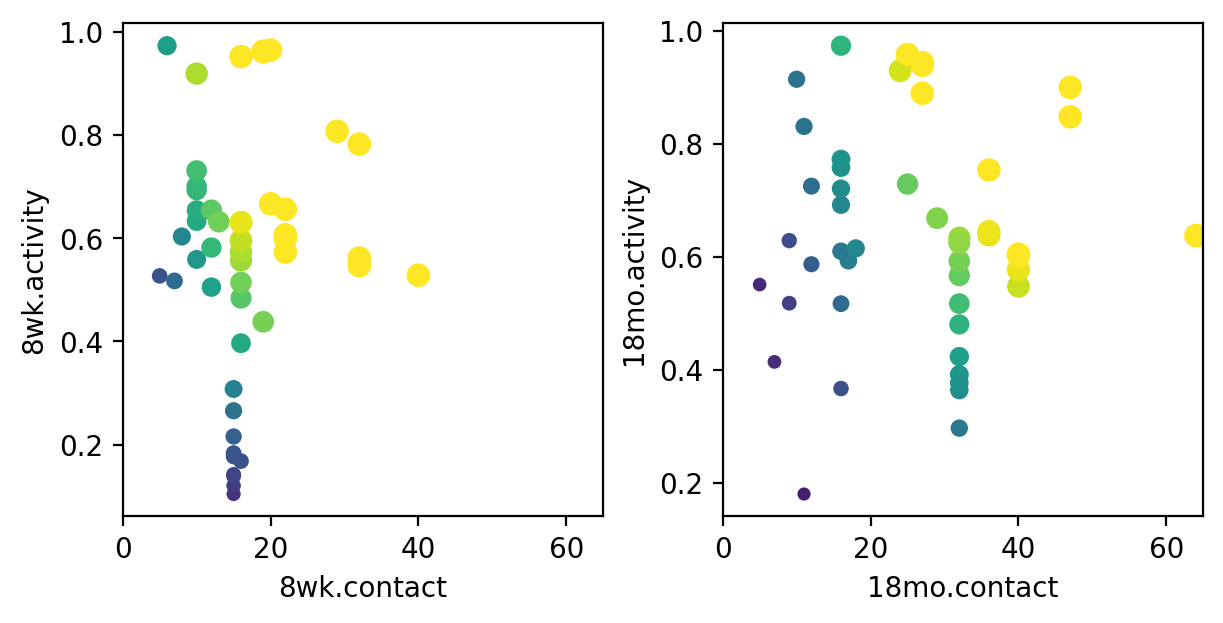

In [24]:
vmin,vmax = 0, 0.6

fig, axes= plt.subplots(figsize = (6,3), ncols = 2,dpi = 200, constrained_layout = True)

ax = axes[0]
age = '8wk'
sns.scatterplot(data = all_abc_score_sorted,
                ax = ax,
                #s = 6,
                linewidth = 0,
                hue = f'{age}.score',
                palette = 'viridis',
                size = f'{age}.score',
                x = f'{age}.contact',
                y = f'{age}.activity',
                hue_norm = (vmin,vmax), 
                size_norm = (vmin,vmax),
                legend = False)
ax.set(xlim = (0,65))

ax = axes[1]
age = '18mo'
sns.scatterplot(data = all_abc_score_sorted,
                ax = ax,
                #s = 6,
                linewidth = 0,
                hue = f'{age}.score',
                palette = 'viridis',
                size = f'{age}.score',
                x = f'{age}.contact',
                y = f'{age}.activity',
                hue_norm = (vmin,vmax), 
                size_norm = (vmin,vmax),
                legend = False)
ax.set(xlim = (0,65))

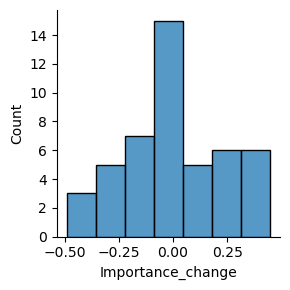

In [25]:
all_abc_score_sorted['Rank_8wk'] = all_abc_score_sorted['8wk.score'].rank()
all_abc_score_sorted['Rank_18mo'] = all_abc_score_sorted['18mo.score'].rank()

all_abc_score_sorted['Importance_8wk'] = all_abc_score_sorted['Rank_8wk']/all_abc_score_sorted.shape[0]
all_abc_score_sorted['Importance_18mo'] = all_abc_score_sorted['Rank_18mo']/all_abc_score_sorted.shape[0]
all_abc_score_sorted['Importance_change'] = all_abc_score_sorted['Importance_18mo'] - all_abc_score_sorted['Importance_8wk']
sns.displot(all_abc_score_sorted['Importance_change'], height=3)

In [26]:
def set_cat(x):
    if x < -0.2:
        cat = 'young_active'
    elif x > 0.2:
        cat = 'old_active'
    else:
        cat = 'both_active'
    return cat
all_abc_score_sorted['cat'] = all_abc_score_sorted['Importance_change'].apply(lambda x: set_cat(x))

In [27]:
all_abc_score_sorted['contact_change'] = all_abc_score_sorted['18mo.contact'] - all_abc_score_sorted['8wk.contact']
all_abc_score_sorted['activity_change'] = all_abc_score_sorted['18mo.activity'] - all_abc_score_sorted['8wk.activity']

In [28]:
slop = 2000
gene_start, gene_end = mouse_genes.loc[gene_id]['start'], mouse_genes.loc[gene_id]['end']
gene_start, gene_end = gene_start- slop, gene_end+slop
gene_start, gene_end

(29923114, 29962718)

In [30]:
all_abc_score_sorted['eg_dist'] = all_abc_score_sorted.index.map(lambda x: genome_pos(x))

Text(0.5, 1.0, 'Activity Change (Young-Old)')

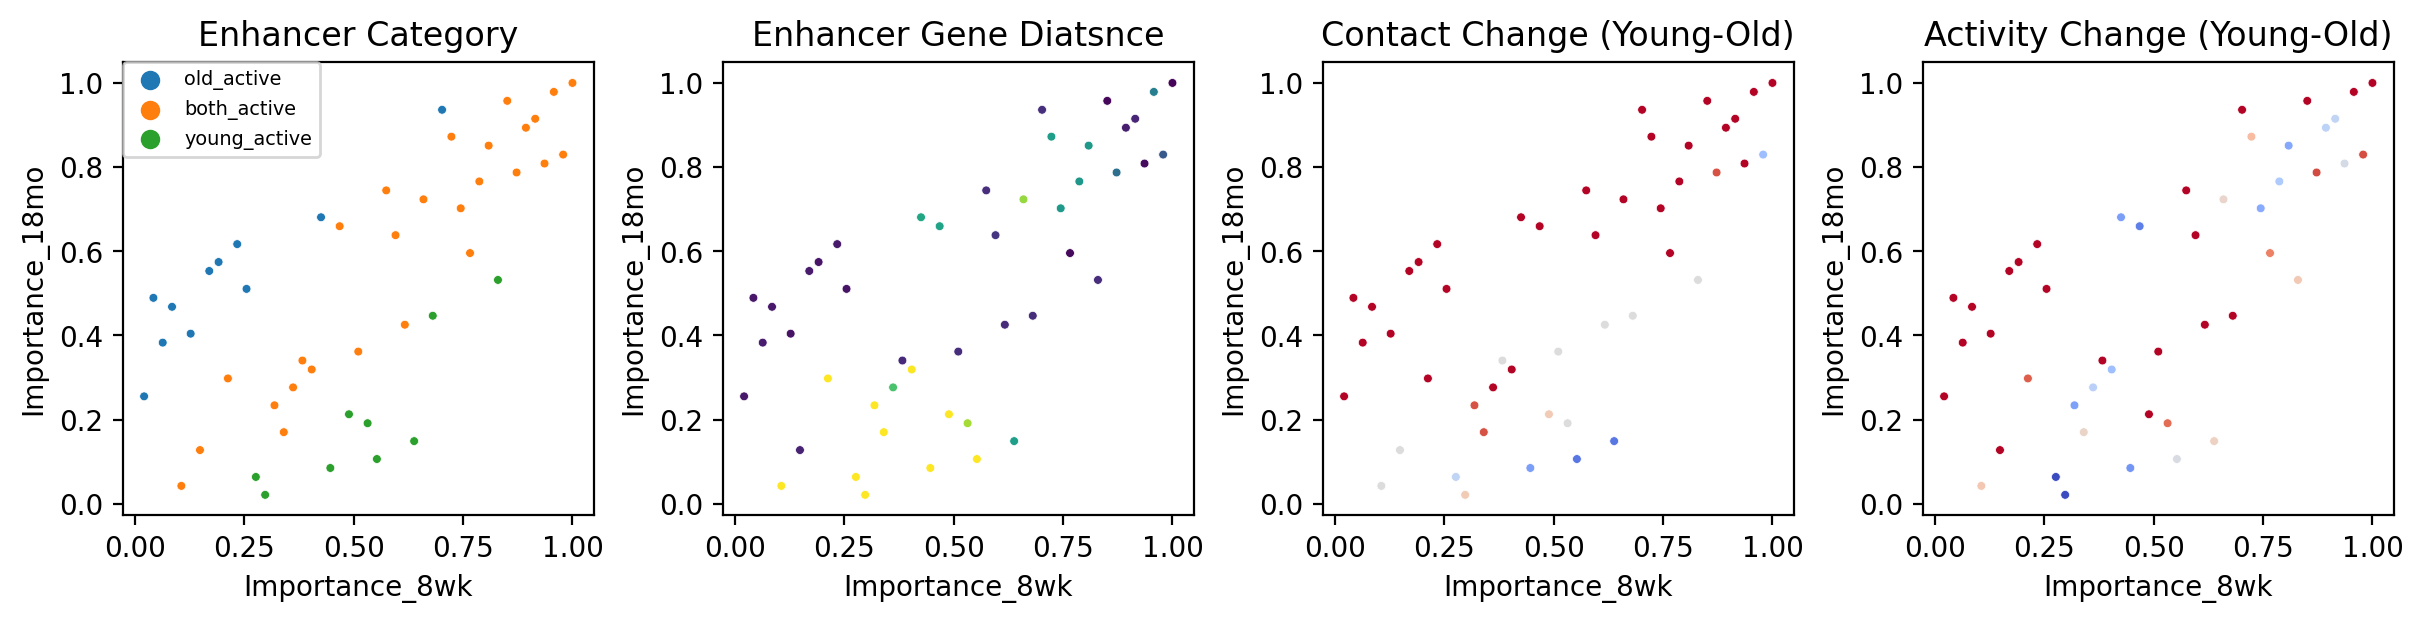

In [45]:
x = 'Importance_8wk'
y = 'Importance_18mo'

fig, axes = plt.subplots(figsize = (12,3), ncols = 4, dpi = 200, constrained_layout = True)

ax= axes[0]
sns.scatterplot(data = all_abc_score_sorted,
                hue = 'cat',
                ax = ax,s =10,
                x = x,
                y = y)
ax.legend(loc='upper left', borderaxespad=0,fontsize='x-small') #bbox_to_anchor=(1.05, 1), 
ax.set_title("Enhancer Category")


ax= axes[1]
sns.scatterplot(data = all_abc_score_sorted,
                hue = 'eg_dist',
                palette ='viridis',
                hue_norm = (0,2e5),
                legend = False,
                ax = ax,s =10,
                x = x,
                y = y)
ax.set_title("Enhancer Gene Diatsnce")

ax= axes[2]
sns.scatterplot(data = all_abc_score_sorted,
                hue = 'contact_change',
                palette ='coolwarm',
                hue_norm = (-5,5),
                legend = False,
                ax = ax,s =10,
                x = x,
                y = y)
ax.set_title("Contact Change (Young-Old)")

ax= axes[3]
sns.scatterplot(data = all_abc_score_sorted,
                hue = 'activity_change',
                palette ='coolwarm',
                hue_norm = (-0.1,0.1),
                legend = False,
                ax = ax,s =10,
                x = x,
                y = y)
ax.set_title("Activity Change (Young-Old)")